# <b>3 - Simple Analytical Methods for Detecting Temporal Process Changes using a Simulated Random Process</b>

<b>Purpose:</b>   
Experiment with using simple feature engineering and descriptive statistics to identify process changes that happened at points in time.   

<b>Simulation:</b>  
A random process has an 80% chance of behaving two ways, with an additional 14% chance of behaving the same but requiring an approval step.   
For a short interval, the process changes to using a flow that normally has a 5% chance of use to having a 89% chance.  

<b>Methods:</b>  
For each arbitrary temporal window (100 cases used) determine metrics on neighboring events, specifically count of cases by neighbors.  
Neighbors is defined as two events in which at least one case had the first event directly followed by the second.  
This is important because volumes by neighbors is important because it contains context of what happened next.   
These neighbor metrics were gathered for all the temporal windows across the case history.  
A distance matrix was created to compare each temporal window to every other temporal window.  
Average and standard deviation statistics were taken of distances and used to create a Z-score for that window. 
The simple Z-score was used to determine outliers. 

<b>Results:</b>  
The simple method correctly identified all cases where the simulated interval used a significantly different process.  

<b>Further application:</b>  
This simple method is not robust enough to perform well against more complex tasks. However, the simple methods   
shown can be built upon towards applying more sophisticated techniques. 

   
-----

<b>Initial Imports</b>   
Imports for specific techniques handled later

In [1]:
import random
from datetime import datetime, timedelta
import pandas as pd
import pm4py

-----

## <b>Simulation</b>

Summary of the random process:   
There are six forms of the process flow. All begin with 'start' and all terminate with 'end'. There's an 80% chance that the process will follow the first two flows. There's a 14% chance of an approval required on a normal flow. There's a 5% chance of a special approval flow. There's a 1% chance of a process bypass. A random number is used to simulate which flow is followed.   
However, for a random interval, the probabilities change an another flow is 89% likely (was 5%).  
10,000 simulations were completed.

In [2]:
process_scenarios = {
                    "a": ['start','a','b','c','end'],
                    "b": ['start','a','d','e','end'],
                    "c": ['start','a','b','c','a_approval','end'],
                    "d": ['start','a','d','e','b_approval','end'],
                    "e": ['start','a','f','f_approval','end'],
                    "f": ['start','bypass','end']
                    }

In [3]:
def get_action_date(f_days):
    process_start_date = datetime(2001,1,1)
    return process_start_date + timedelta(f_days)
    

In [4]:
def get_scenario(f_rand_val, f_scenarios, f_outlier):
    if f_outlier == 0:
        tmp_val = ''
        tmp_val = f_scenarios['a'] if (f_rand_val <= 40) else tmp_val                              # 40% chance A
        tmp_val = f_scenarios['b'] if (f_rand_val > 40 and f_rand_val <= 80) else tmp_val          # 40% chance B
        tmp_val = f_scenarios['c'] if (f_rand_val > 80 and f_rand_val <= 87) else tmp_val          # 7% chance C
        tmp_val = f_scenarios['d'] if (f_rand_val > 87 and f_rand_val <= 94) else tmp_val          # 7% chance D
        tmp_val = f_scenarios['e'] if (f_rand_val > 94 and f_rand_val <= 99) else tmp_val          # 5% chance E
        tmp_val = f_scenarios['f'] if (f_rand_val > 99) else tmp_val                               # 1% chance F
    if f_outlier == 1:
        tmp_val = ''                                                                               # 0% chance A or B
        tmp_val = f_scenarios['c'] if (f_rand_val <= 5) else tmp_val                               # 5% chance C
        tmp_val = f_scenarios['d'] if (f_rand_val > 5 and f_rand_val <= 10) else tmp_val           # 5% chance D
        tmp_val = f_scenarios['e'] if (f_rand_val > 10 and f_rand_val <= 99) else tmp_val          # 89% chance E
        tmp_val = f_scenarios['f'] if (f_rand_val > 99) else tmp_val                               # 1% chance F
    return tmp_val

In [5]:
def simulate_event(f_flow_id, f_date_id, f_outlier_flag):
    rand_event = int( round( random.random() * 100 , 2))
    tmp_date_id = f_date_id
    flow_scenario = get_scenario( rand_event, process_scenarios ,f_outlier_flag)
    tmp_flow = []
    for flow in flow_scenario: 
        event_date = get_action_date(tmp_date_id)
        tmp_date_id += 1
        tmp_flow.append([f_flow_id, event_date.strftime('%m/%d/%Y'), flow])
    return tmp_flow, tmp_date_id

In [6]:
date_id = 1
flow_id = 1
simulation_list = []
while flow_id < 10001:
    if flow_id > 5000 and flow_id <= 5501: 
        outlier_flag = 1
    else: 
        outlier_flag = 0
    sim_flow, date_id = simulate_event(flow_id, date_id,outlier_flag)
    for event in sim_flow:
        simulation_list.append(event)
    flow_id += 1

In [7]:
simulation_df = pd.DataFrame(simulation_list)

In [8]:
simulation_df.columns = ['flow_id','event_date','event']

----- 

## <b>Process Mining</b>

In this section, two flows will be shown: (1) expected flow, (2) changed flow.   
Next, the analysis decribed will be performed.  
Then, the results of the analysis will be shown,   
and the flows resulting from the analysis will be visualized. 

### <b>Initial set up</b>

In [9]:
from pm4py.objects.log.util import dataframe_utils
from pm4py.objects.conversion.log import converter as log_converter

In [10]:
sim_event_df = dataframe_utils.convert_timestamp_columns_in_df(simulation_df)

In [11]:
sim_event_df = sim_event_df.sort_values('event_date')

In [12]:
sim_event_df.columns = ['case:concept:name','time:timestamp','concept:name']

In [13]:
sim_normevent_df = sim_event_df[sim_event_df['case:concept:name'] < 5000]
sim_outevent_df = sim_event_df[(sim_event_df['case:concept:name'] > 5000) & (sim_event_df['case:concept:name'] < 5500) ]

In [14]:
log_util_params = {log_converter.Variants.TO_EVENT_LOG.value.Parameters.CASE_ID_KEY: 'case:concept:name'}

In [15]:
sim_event_log = log_converter.apply(sim_event_df, parameters=log_util_params, variant=log_converter.Variants.TO_EVENT_LOG)
sim_normevent_log = log_converter.apply(sim_normevent_df, parameters=log_util_params, variant=log_converter.Variants.TO_EVENT_LOG)
sim_outevent_log = log_converter.apply(sim_outevent_df, parameters=log_util_params, variant=log_converter.Variants.TO_EVENT_LOG)

In [16]:
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.visualization.petrinet import visualizer as pn_visualizer
viz_params = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: "png"}

In [17]:
all_net, all_initial_marking, all_final_marking = alpha_miner.apply(sim_event_log)
norm_net, norm_initial_marking, norm_final_marking = alpha_miner.apply(sim_normevent_log)
out_net, out_initial_marking, out_final_marking = alpha_miner.apply(sim_outevent_log)

### <b>Expected normal flow example</b>

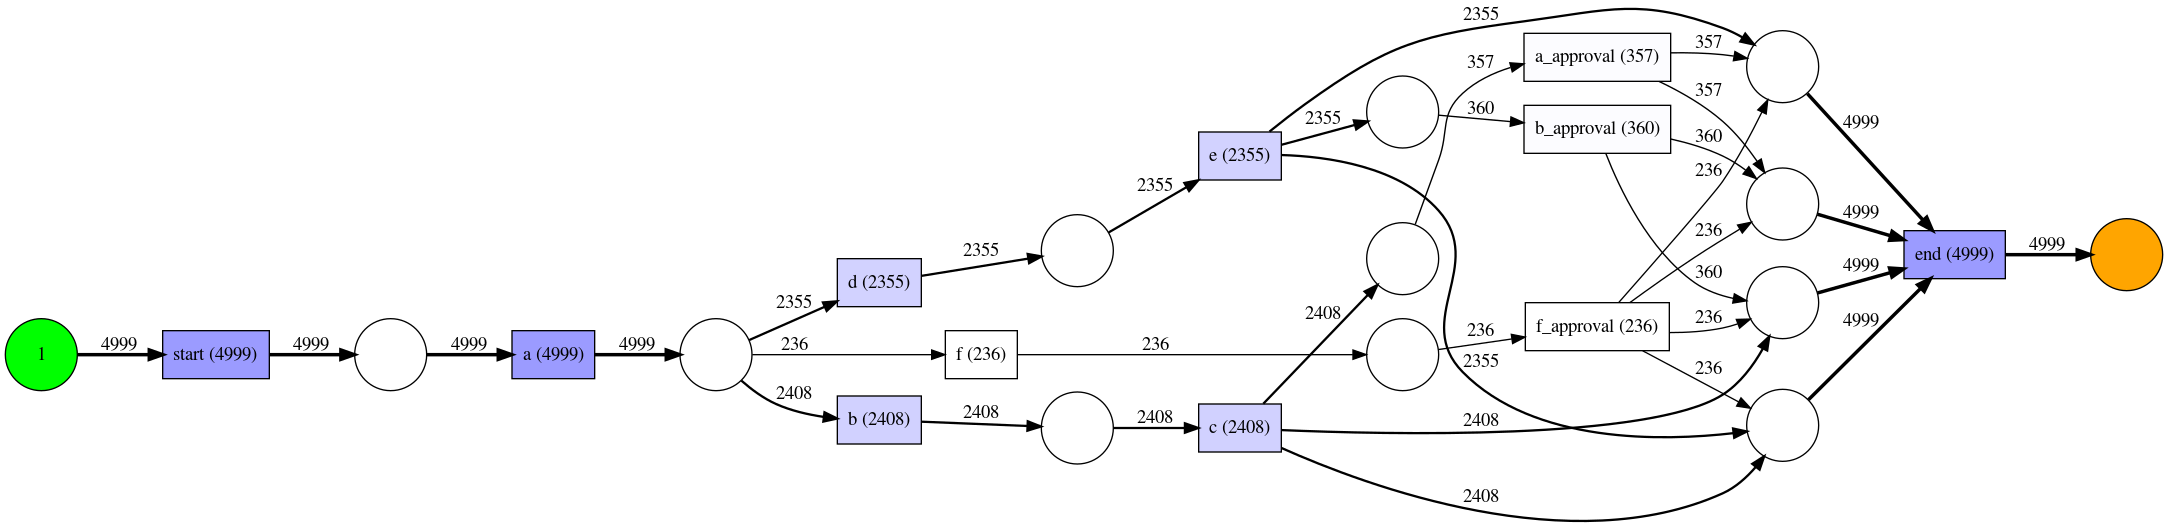

In [18]:
norm_gviz_am = pn_visualizer.apply(norm_net, norm_initial_marking, norm_final_marking,
                             parameters = viz_params,
                             variant=pn_visualizer.Variants.FREQUENCY,
                             log=sim_normevent_log)
pn_visualizer.view(norm_gviz_am)

### <b>Process change flow example</b>

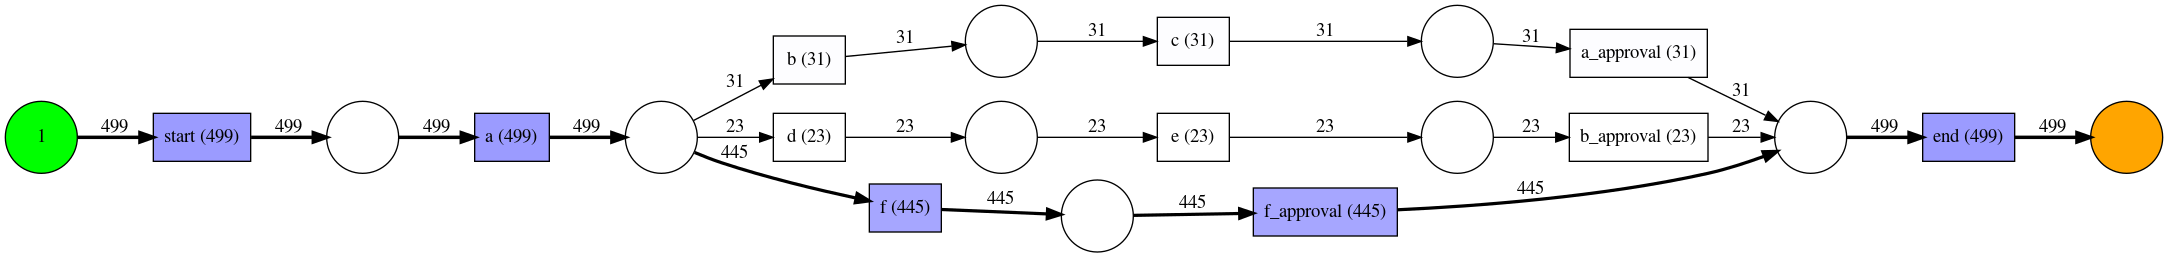

In [19]:
out_gviz_am = pn_visualizer.apply(out_net, out_initial_marking, out_final_marking,
                             parameters = viz_params,
                             variant=pn_visualizer.Variants.FREQUENCY,
                             log=sim_outevent_log)
pn_visualizer.view(out_gviz_am)

### <b>Process analysis</b>

In [20]:
from pm4py.objects.log.util import get_log_representation

In [21]:
def neighbors_metrics(f_log):
    """
    Intakes the log for a temporal window. 
    Processes case count metrics for in scope event neighbors. 
    Returns pandas dataframe. 
    """
    try:
        tmp_data, tmp_feature_names = get_log_representation.get_representation(f_log, str_ev_attr=["case:concept:name", "concept:name"],
                                                                    str_tr_attr=[], num_ev_attr=[], num_tr_attr=[],
                                                                    str_evsucc_attr=["case:concept:name", "concept:name"])
        tmp_df = pd.DataFrame(tmp_data, columns = tmp_feature_names)
        tmp_agg = pd.DataFrame( tmp_df.sum() )
        tmp_agg.columns = ['case_count']
        tmp_agg = tmp_agg.iloc[tmp_agg.index.str.contains('success')]
        tmp_agg = tmp_agg.iloc[~tmp_agg.index.str.contains('case:concept')]
        tmp_agg.index = tmp_agg.index.str.replace('succession:concept:name@','')
        tmp_agg.index = tmp_agg.index.str.replace('#','_to_')
        tot_case_cnt = tmp_agg['case_count'].max()
        tmp_agg['norm_val'] = tmp_agg.loc[:,'case_count'].apply(lambda x : x / tot_case_cnt)
        tmp_agg = pd.DataFrame( tmp_agg.loc[~tmp_agg.index.isin(['start_to_a']), 'norm_val'] ) 
        base_neighbors_df = pd.DataFrame( [0,0,0,0,0,0,0,0,0,0,0,0,0] )
        base_neighbors_df.index = ['a_to_b',
         'a_to_d',
         'a_to_f',
         'a_approval_to_end',
         'b_to_c',
         'b_approval_to_end',
         'c_to_a_approval',
         'c_to_end',
         'd_to_e',
         'e_to_b_approval',
         'e_to_end',
         'f_to_f_approval',
         'f_approval_to_end']

        norm_merge = base_neighbors_df.merge(tmp_agg, how='left', left_index=True,right_index=True)
        norm_merge['norm_val'] = norm_merge['norm_val'].fillna(0)
        fnl_row = norm_merge['norm_val'].T.to_list()
        fnl = pd.DataFrame( [fnl_row] )
        fnl.columns = ['a_to_b',
         'a_to_d',
         'a_to_f',
         'a_approval_to_end',
         'b_to_c',
         'b_approval_to_end',
         'c_to_a_approval',
         'c_to_end',
         'd_to_e',
         'e_to_b_approval',
         'e_to_end',
         'f_to_f_approval',
         'f_approval_to_end']
        return fnl
    except:
        print('Error in processing metrics')

In [22]:
batch_event_range = range(0,10000,100)
results_df = pd.DataFrame(columns = ['a_to_b',
         'a_to_d',
         'a_to_f',
         'a_approval_to_end',
         'b_to_c',
         'b_approval_to_end',
         'c_to_a_approval',
         'c_to_end',
         'd_to_e',
         'e_to_b_approval',
         'e_to_end',
         'f_to_f_approval',
         'f_approval_to_end'])
for batch in batch_event_range: 
    batch_sim_df = sim_event_df[(sim_event_df['case:concept:name'] >= batch) & (sim_event_df['case:concept:name'] < batch + 100)]
    batch_sim_log = log_converter.apply(batch_sim_df, parameters=log_util_params, variant=log_converter.Variants.TO_EVENT_LOG)
    batch_metrics = neighbors_metrics(batch_sim_log)
    batch_metrics.index = [batch]
    results_df = results_df.append(batch_metrics, ignore_index=False)

In [23]:
from scipy.spatial import distance_matrix

In [24]:
neighbor_distance = pd.DataFrame(distance_matrix(results_df.values, results_df.values), index=results_df.index, columns=results_df.index)

In [25]:
avg_neighbor_distance = pd.DataFrame( neighbor_distance.mean() )

In [26]:
avg_neighbor_distance.columns = ['Avg_Distance_of_Case_Cnt']

In [27]:
avg_neighbor_distance['Batch_ID'] = avg_neighbor_distance.index

In [28]:
avg_neighbor_distance = avg_neighbor_distance.sort_values('Avg_Distance_of_Case_Cnt', ascending=False)

In [29]:
std_dev = avg_neighbor_distance['Avg_Distance_of_Case_Cnt'].std()

In [30]:
avg = avg_neighbor_distance['Avg_Distance_of_Case_Cnt'].mean()

In [31]:
avg_neighbor_distance['Dist_Z_Score'] = avg_neighbor_distance['Avg_Distance_of_Case_Cnt'].apply(lambda x: abs( x - avg ) / std_dev )

In [32]:
avg_neighbor_distance.loc[ avg_neighbor_distance['Dist_Z_Score'] > 3, 'Outlier_Flag'] = 'Y'
avg_neighbor_distance.loc[ avg_neighbor_distance['Dist_Z_Score'] <= 3, 'Outlier_Flag'] = 'N'

### <b>Display analysis results</b>

There are 5 outliers, which at the 5 100-event temporal windows that were when the process changed. 

In [33]:
pd.DataFrame(avg_neighbor_distance['Outlier_Flag'].value_counts(sort=True))

,Outlier_Flag
N,95
Y,5


These are the values for the 5 outlier temporal windows. 

In [34]:
avg_neighbor_distance[ avg_neighbor_distance['Outlier_Flag'] == 'Y']

,Avg_Distance_of_Case_Cnt,Batch_ID,Dist_Z_Score,Outlier_Flag
5200,1.773523,5200,4.526727,Y
5400,1.734309,5400,4.403445,Y
5300,1.698117,5300,4.289668,Y
5100,1.648573,5100,4.133914,Y
5000,1.642690,5000,4.115418,Y


These are an example of non-outlier temporal windows. 

In [35]:
avg_neighbor_distance[ avg_neighbor_distance['Outlier_Flag'] == 'N'].head()

,Avg_Distance_of_Case_Cnt,Batch_ID,Dist_Z_Score,Outlier_Flag
3700,0.425154,3700,0.287785,N
6200,0.407335,6200,0.231765,N
2500,0.390966,2500,0.180306,N
8500,0.385814,8500,0.164110,N
4400,0.385257,4400,0.162357,N


This is a scatter plot showing the widely different temporal windows. 

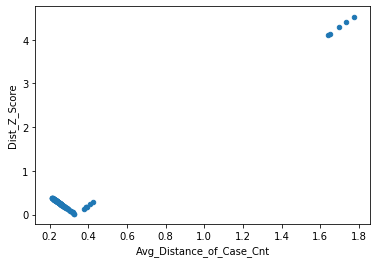

In [36]:
avg_neighbor_distance.plot.scatter(x='Avg_Distance_of_Case_Cnt',
                                  y='Dist_Z_Score')

In [37]:
outlier_batch_list = avg_neighbor_distance[ avg_neighbor_distance['Outlier_Flag'] == 'Y'].index.to_list()
norm_batch_list = avg_neighbor_distance[ avg_neighbor_distance['Outlier_Flag'] == 'N'].index.to_list()
outlier_to_show = outlier_batch_list[0]
norm_to_show = norm_batch_list[0]

### <b>Example outlier flow from the analysis</b>

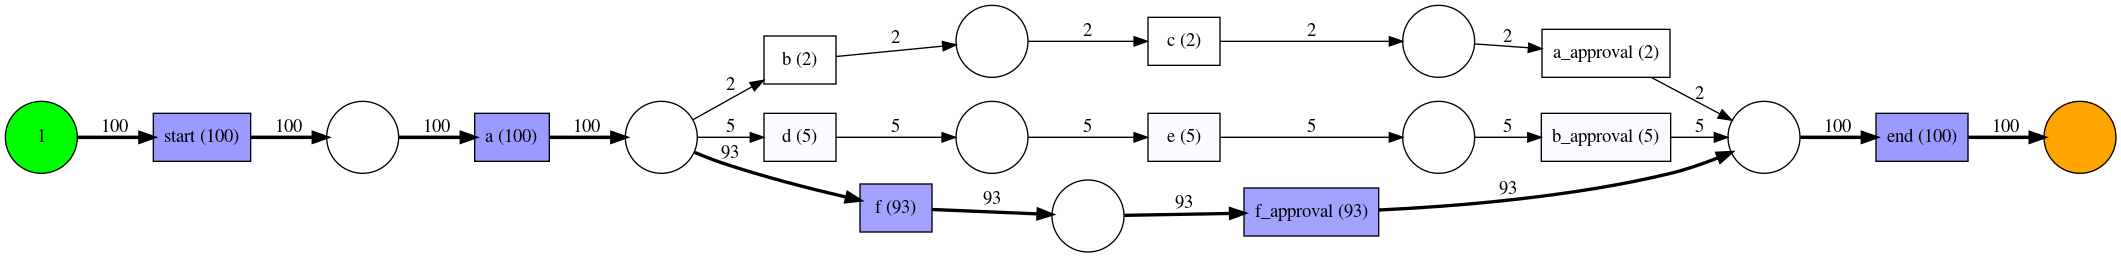

In [38]:
outlier_show_df = sim_event_df[(sim_event_df['case:concept:name'] >= outlier_to_show) & (sim_event_df['case:concept:name'] < outlier_to_show + 100)]
outlier_show_log = log_converter.apply(outlier_show_df, parameters=log_util_params, variant=log_converter.Variants.TO_EVENT_LOG)
outlier_net, outlier_initial_marking, outlier_final_marking = alpha_miner.apply(outlier_show_log)
outlier_gviz_am = pn_visualizer.apply(outlier_net, outlier_initial_marking, outlier_final_marking,
                             parameters = viz_params,
                             variant=pn_visualizer.Variants.FREQUENCY,
                             log=outlier_show_log)
pn_visualizer.view(outlier_gviz_am)

### <b>Example normal flow from the analysis</b>

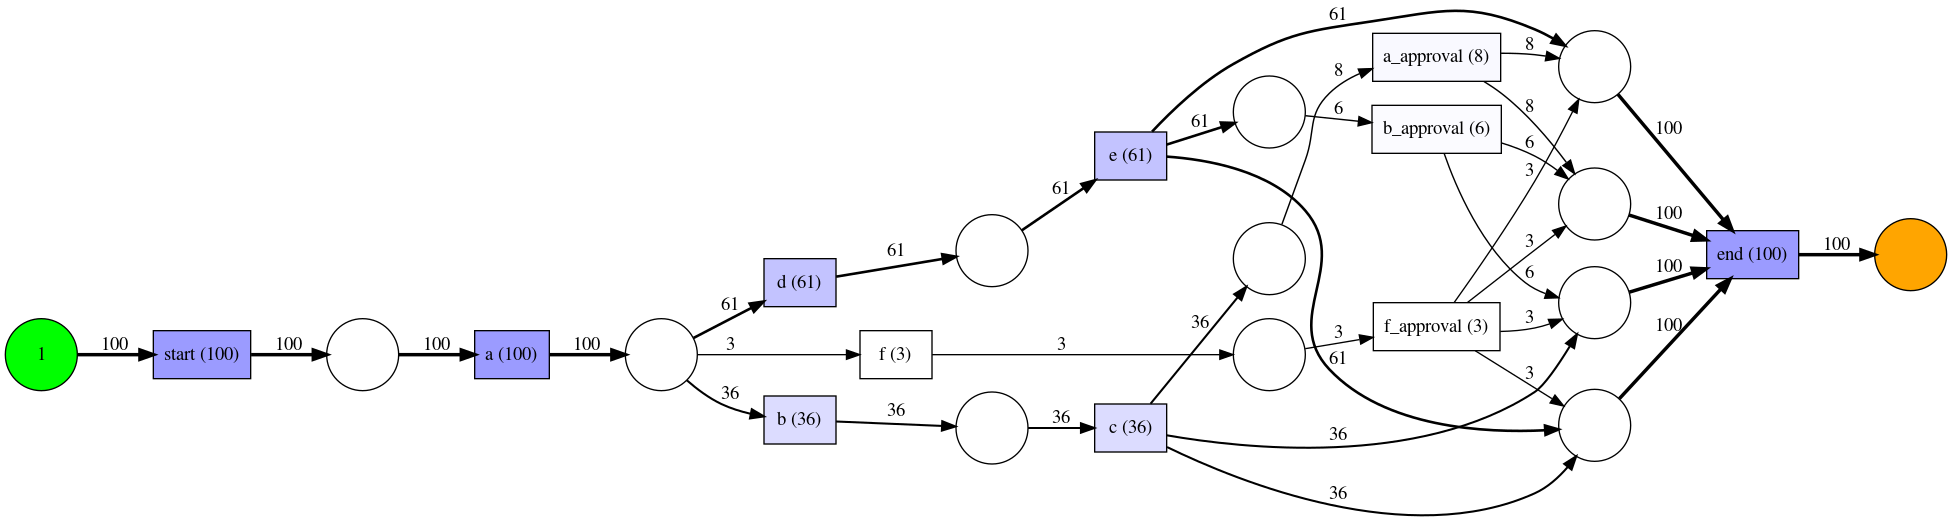

In [39]:
norm_show_df = sim_event_df[(sim_event_df['case:concept:name'] >= norm_to_show) & (sim_event_df['case:concept:name'] < norm_to_show + 100)]
norm_show_log = log_converter.apply(norm_show_df, parameters=log_util_params, variant=log_converter.Variants.TO_EVENT_LOG)
norm_net, norm_initial_marking, norm_final_marking = alpha_miner.apply(norm_show_log)
norm_gviz_am = pn_visualizer.apply(norm_net, norm_initial_marking, norm_final_marking,
                             parameters = viz_params,
                             variant=pn_visualizer.Variants.FREQUENCY,
                             log=norm_show_log)
pn_visualizer.view(norm_gviz_am)